In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import os

from utils import normalize
from torch.utils.data import DataLoader

from mod_moving_mnist import ModMovingMNISTDataset
from mpnnlstm import NextFramePredictorS2S
from model import MPNNLSTM, MPNNLSTMI

/Users/zach/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
np.random.seed(1)
random.seed(1)
torch.manual_seed(1)

def collate_fn(batch):
    return batch[0]

input_features = 1
input_timesteps = 4
output_timesteps = 10

# Create a dataset using the modified MovingMNIST
mnist_kwargs = dict(
    input_timesteps=input_timesteps,
    output_timesteps=output_timesteps,
    n_digits=1,
    gap=0,
    canvas_size=(32, 32),
    digit_size=(18, 18),
    pixel_noise=0.05,
    velocity_noise=0.0#1  # 0.15
)

# Create a train set (500), test set (50), and validation set (50)
data_train = ModMovingMNISTDataset(200, **mnist_kwargs)
data_test = ModMovingMNISTDataset(50, **mnist_kwargs)
data_val = ModMovingMNISTDataset(50, **mnist_kwargs)

loader_train = DataLoader(data_train, batch_size=1, shuffle=True)
loader_test = DataLoader(data_test, batch_size=1, shuffle=True)
loader_val = DataLoader(data_val, batch_size=1, shuffle=False)

In [14]:
from mpnnlstm import NextFramePredictor

from torch.optim.lr_scheduler import StepLR
import time
import pandas as pd
from tqdm import tqdm

from graph_functions import image_to_graph, flatten, create_graph_structure, unflatten
from utils import add_positional_encoding

np.random.seed(1)
random.seed(1)
torch.manual_seed(1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('mps')

# Add 3 to the number of input features since we add positional encoding (x, y) and node size (s)
model_kwargs = dict(
    hidden_size=16,
    dropout=0.1,
    n_layers=2
)


model = NextFramePredictorS2S(
    thresh=0.1,
    experiment_name='test',
    decompose=True,
    input_features=1,
    device=device,
    output_timesteps=output_timesteps,
    remesh_input=False,
    model_kwargs=model_kwargs)

model.get_n_params()

8081

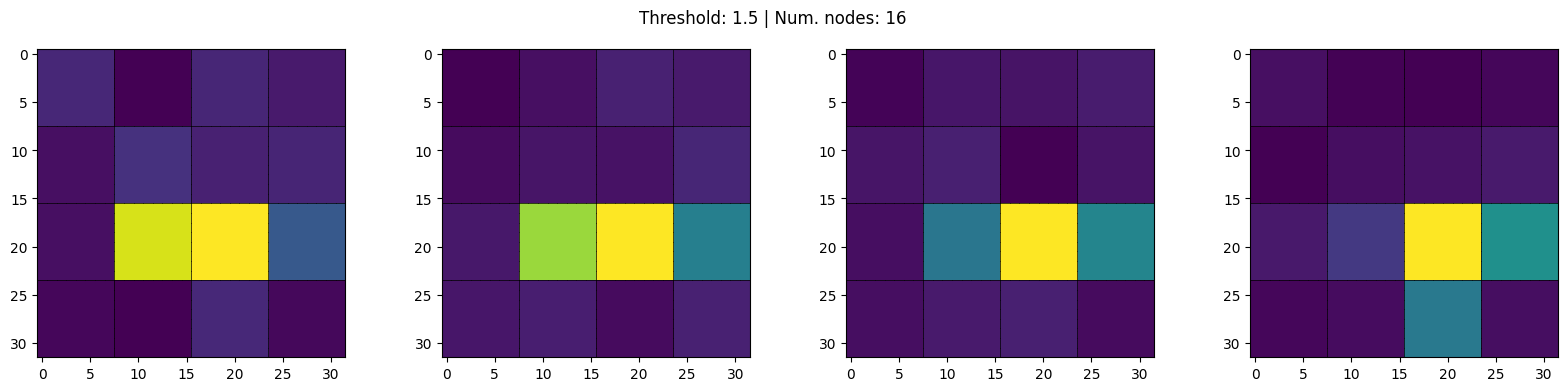

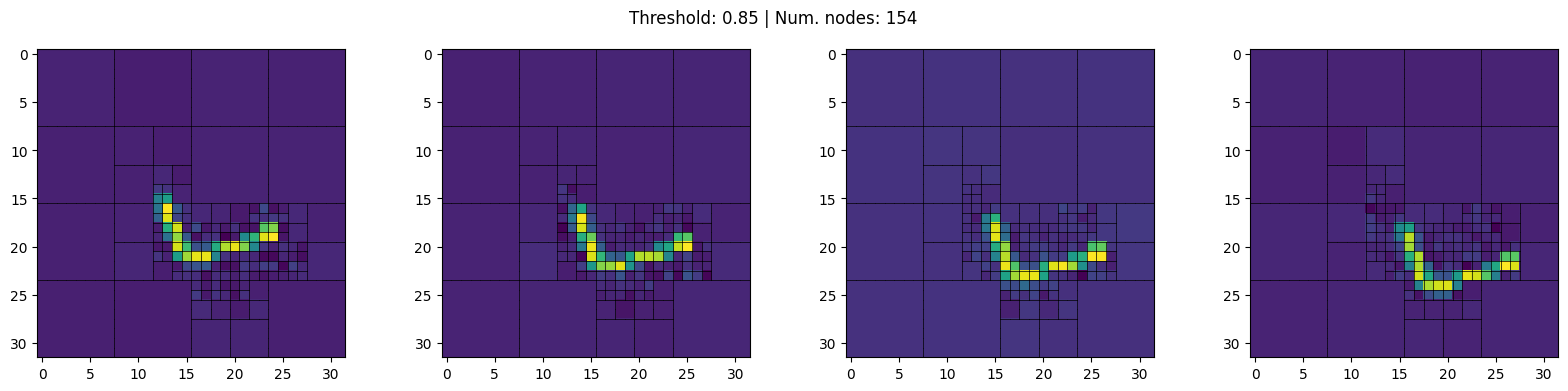

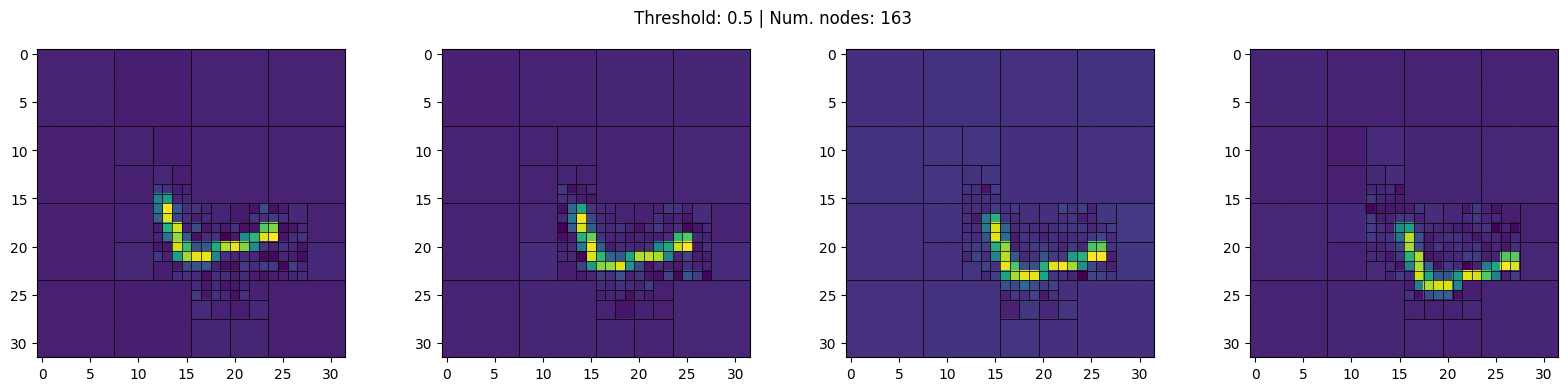

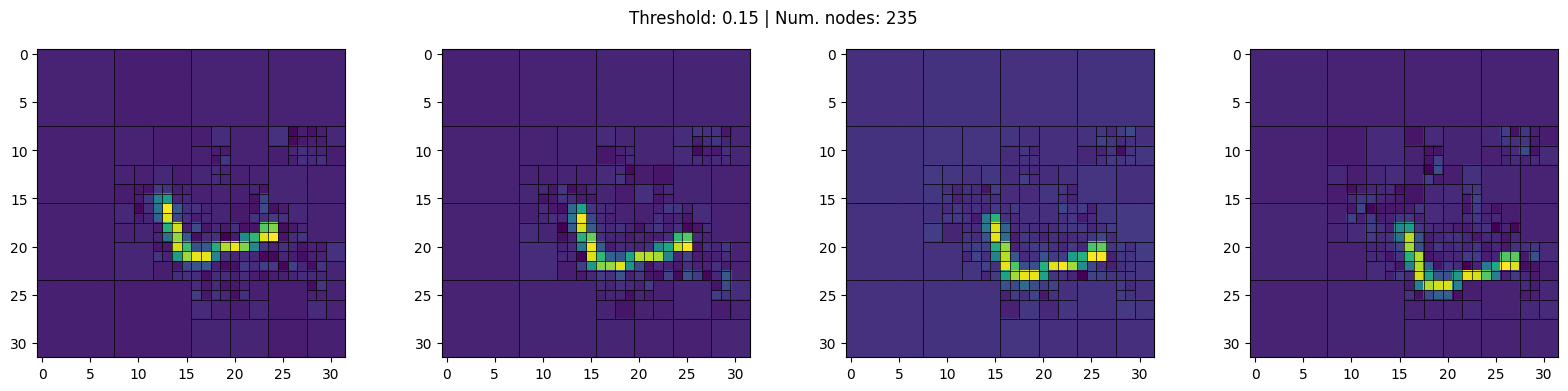

In [11]:
x, _, _ = next(iter(loader_val))
x = x.squeeze(0)

fig, axs = model.test_threshold(x, thresh=1.5)
plt.show()

fig, axs = model.test_threshold(x, thresh=0.85)
plt.show()

fig, axs = model.test_threshold(x, thresh=0.5)
plt.show()

fig, axs = model.test_threshold(x, thresh=0.15)
plt.show()

In [27]:
import cProfile
loader_profile = DataLoader(data_train, batch_size=1, sampler=torch.utils.data.SubsetRandomSampler(range(10)))
cProfile.run('model.train(loader_profile, loader_profile, lr=0.01, n_epochs=1)', sort=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.42it/s]

Epoch 0 train MSE: 0.2151, test MSE: 0.2235, lr: 0.0100, time_per_epoch: 5.7
Finished in 0.09435171683629354 minutes
         5053339 function calls (4841411 primitive calls) in 5.678 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10    1.006    0.101    1.006    0.101 {method 'run_backward' of 'torch._C._EngineBase' objects}
      220    0.664    0.003    0.745    0.003 graph_functions.py:203(get_adj)
      220    0.367    0.002    0.424    0.002 graph_functions.py:98(quadtree_decompose)
    12480    0.362    0.000    0.362    0.000 {method 'scatter_add_' of 'torch._C._TensorBase' objects}
     6240    0.252    0.000    0.374    0.000 gcn_conv.py:33(gcn_norm)
     1420    0.205    0.000    0.205    0.000 {method 'to_dense' of 'torch._C._TensorBase' objects}
      220    0.177    0.001    0.275    0.001 graph_functions.py:33(create_graph_structure)
     6240    0.143    0.000    1.524    0.000 gcn_conv.py:168(forwar

In [ ]:
model = NextFramePredictorS2S(
    thresh=0.1,
    experiment_name='test',
    decompose=True,
    input_features=1,
    device=device,
    output_timesteps=output_timesteps,
    remesh_input=False,
    model_kwargs=model_kwargs)

model.train(loader_train, loader_test, lr=0.01, n_epochs=20)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.71it/s]


Epoch 0 train MSE: 0.0524, test MSE: 0.0370, lr: 0.0100, time_per_epoch: 46.4


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.49it/s]


Epoch 1 train MSE: 0.0361, test MSE: 0.0369, lr: 0.0100, time_per_epoch: 43.0


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.85it/s]


Epoch 2 train MSE: 0.0360, test MSE: 0.0368, lr: 0.0095, time_per_epoch: 41.6


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.69it/s]


Epoch 3 train MSE: 0.0359, test MSE: 0.0364, lr: 0.0095, time_per_epoch: 41.1


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.43it/s]


Epoch 4 train MSE: 0.0354, test MSE: 0.0362, lr: 0.0095, time_per_epoch: 41.3


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.96it/s]


Epoch 5 train MSE: 0.0350, test MSE: 0.0354, lr: 0.0090, time_per_epoch: 41.8


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.74it/s]


Epoch 6 train MSE: 0.0345, test MSE: 0.0350, lr: 0.0090, time_per_epoch: 42.2


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.50it/s]


Epoch 7 train MSE: 0.0340, test MSE: 0.0343, lr: 0.0090, time_per_epoch: 42.6


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.62it/s]


Epoch 8 train MSE: 0.0336, test MSE: 0.0343, lr: 0.0086, time_per_epoch: 42.8


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.23it/s]


Epoch 9 train MSE: 0.0334, test MSE: 0.0339, lr: 0.0086, time_per_epoch: 42.9


 46%|█████████████████████████████████████████▊                                                | 93/200 [00:17<00:20,  5.13it/s]/Users/zach/Documents/Quadtree-MPNNLSTM/graph_functions.py:302: UserWarning: Matrix multiplication in flatten() failed, trying again.
  warnings.warn('Matrix multiplication in flatten() failed, trying again.')
100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.53it/s]


Epoch 10 train MSE: 0.0331, test MSE: 0.0339, lr: 0.0086, time_per_epoch: 43.1


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.07it/s]


Epoch 11 train MSE: 0.0329, test MSE: 0.0345, lr: 0.0081, time_per_epoch: 43.3


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.67it/s]


Epoch 12 train MSE: 0.0327, test MSE: 0.0329, lr: 0.0081, time_per_epoch: 43.5


100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.56it/s]


Epoch 13 train MSE: 0.0324, test MSE: 0.0331, lr: 0.0081, time_per_epoch: 43.8


 56%|█████████████████████████████████████████████████▊                                       | 112/200 [00:22<00:19,  4.42it/s]

<Axes: >

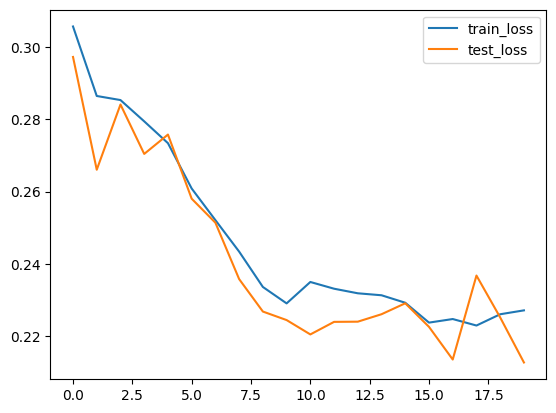

In [24]:
model.loss.plot() 

In [16]:
y_hat = model.predict(loader_val)

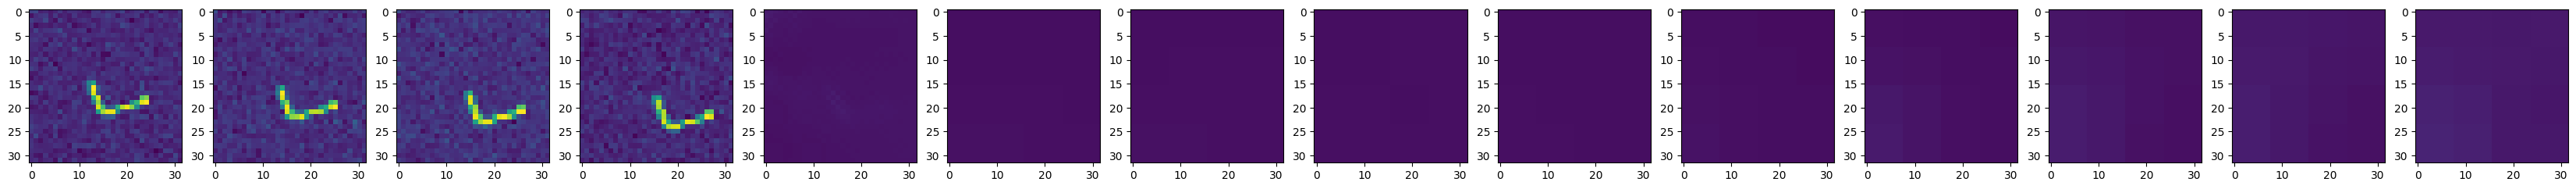

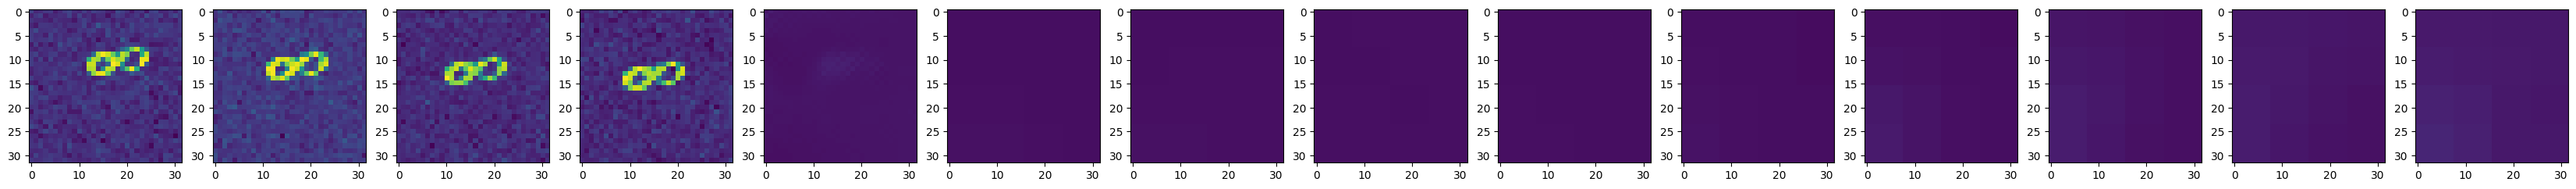

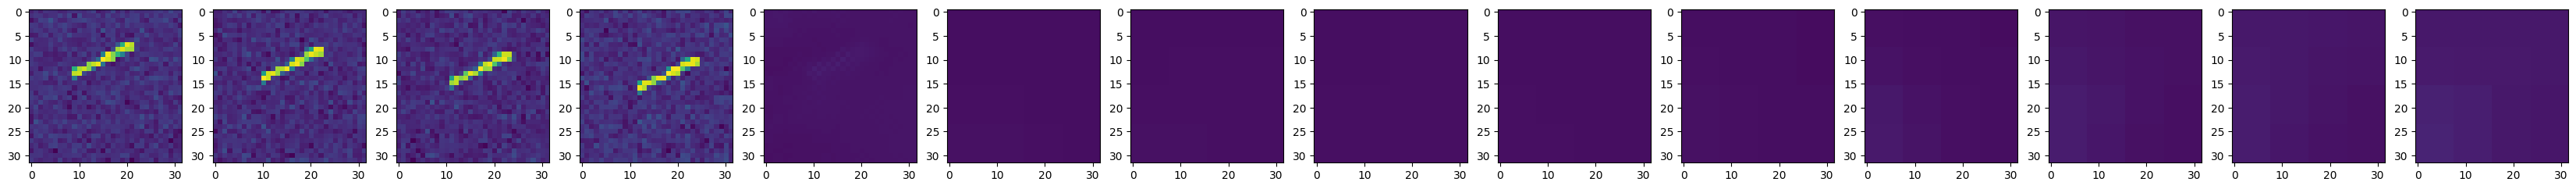

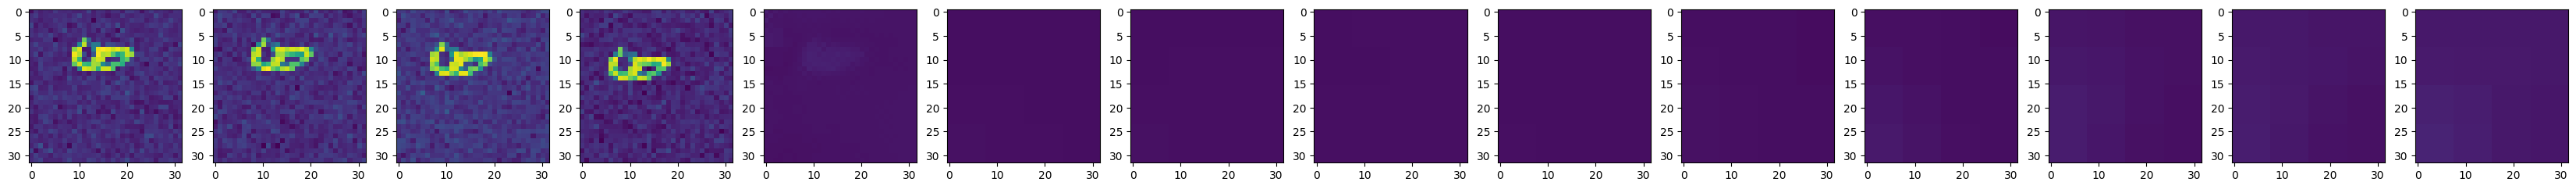

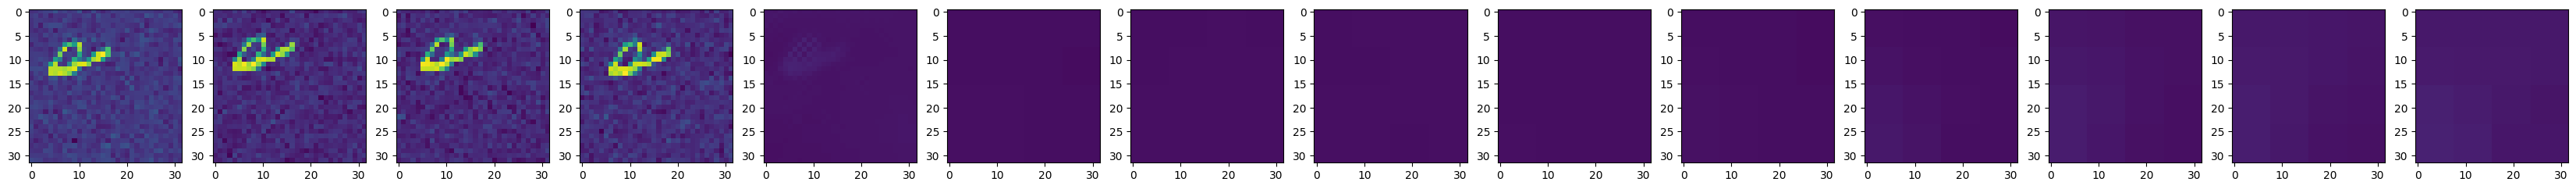

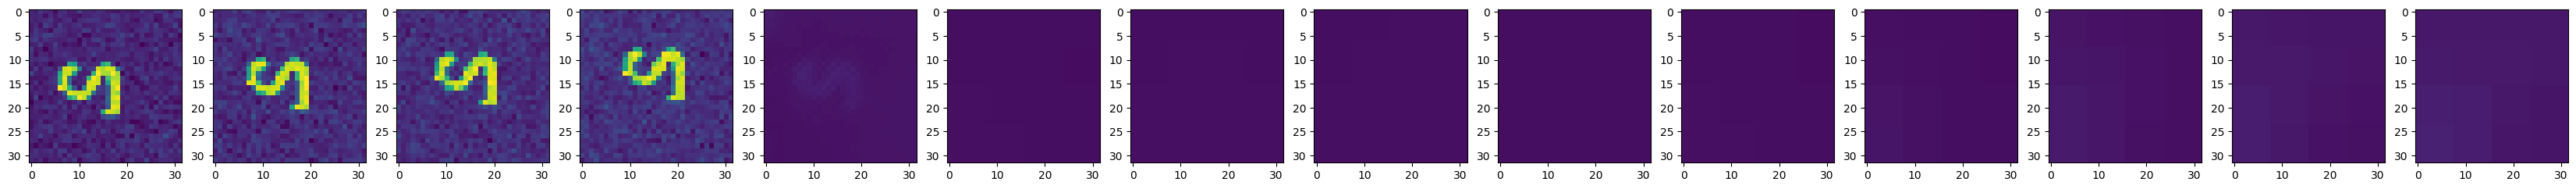

In [17]:
# Plot some example 
num_frames = 6

for i in range(num_frames):
    fig, axs = plt.subplots(1, input_timesteps+output_timesteps, figsize=(3*(input_timesteps+output_timesteps), 4))
    
    # Inputs
    for j in range(input_timesteps):
        axs[j].imshow(loader_val.dataset.x[i][j, ..., 0])
    
    for j in range(output_timesteps):
        axs[input_timesteps+j].imshow(y_hat[i][j][..., 0], vmin=0, vmax=1)  # Prediction

In [ ]:
model.loss.iloc[1:].plot()